In [116]:
import requests
import glob
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import imread,subplot,imshow,show
import seaborn as sns
from influxdb import InfluxDBClient

In [117]:
#import xgboost
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [119]:
r = requests.get('https://api.nysmesonet.org/data/dynserv/coned/5min/nyc/20211101T0000/20211201T0000?stations=bkbrow,bkmapl,bknyrd,bxvnst,mhalph,mhchel,mhmhil,qnasto,qncoro,qndkil,qnhbea,qnlici,qnmasp,qnsozo,qntlcc,sifkil&timezone=America/New_York&variables[]=tair@degF&variables[]=relh@percent')
df = pd.read_csv(io.StringIO(r.text))
df = df.groupby('datetime', as_index=False).median().iloc[:-1]
df.to_csv('mesonet_temp2021_11.csv')

In [ ]:
month_dict = {}
year = '2021'
for month in range(1,12):
    month2 = str(month+1).zfill(2)
    month = str(month).zfill(2)
    
    print('Querying Month '+month)
    
    r = requests.get('https://api.nysmesonet.org/data/dynserv/coned/5min/nyc/'+year+month+'01T0000/'+year+month2+'01T0000?stations=bkbrow,bkmapl,bknyrd,bxvnst,mhalph,mhchel,mhmhil,qnasto,qncoro,qndkil,qnhbea,qnlici,qnmasp,qnsozo,qntlcc,sifkil&timezone=America/New_York&variables[]=tair@degF&variables[]=relh@percent')
    df = pd.read_csv(io.StringIO(r.text))
    df = df.groupby('datetime', as_index=False).median().iloc[:-1]
    df.to_csv('mesonet_temp2021_'+month+'.csv')
    month_dict[month] = df
    
                 

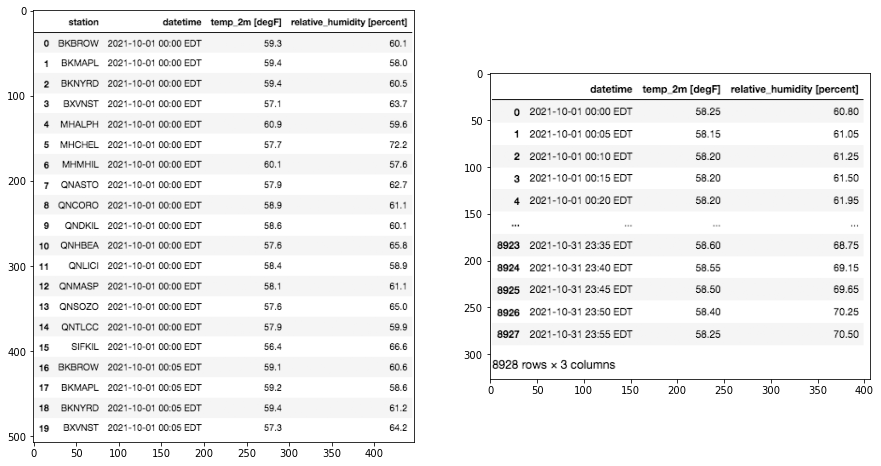

In [112]:
image1 = imread('temps_by_station.png')
image2 = imread('temps_grouped.png')

fig, ax = plt.subplots(1,2, figsize=(15,12))

ax[0].imshow(image1)
ax[1].imshow(image2)


In [4]:
def F_to_C(F):
    C = (F - 32) * (5/9)
    return C

cols = {'datetime':'localtime', 'temp_2m [degF]':'temp_F', 'relative_humidity [percent]':'humidity'}

temps = pd.concat(map(pd.read_csv, glob.glob('mesonet_weather/*.csv'))).iloc[:,1:].dropna()
temps = temps.rename(columns=cols)
temps['localtime'] = pd.to_datetime(temps['localtime']).dt.tz_convert('US/Eastern')
temps.insert(1, 'temp_C', temps['temp_F'].apply(F_to_C))
temps.drop(columns='temp_F', inplace=True)

In [5]:
temps

,localtime,temp_C,humidity
0,2020-10-10 00:00:00-04:00,17.166667,51.20
1,2020-10-10 00:05:00-04:00,17.111111,51.50
2,2020-10-10 00:10:00-04:00,17.111111,51.60
3,2020-10-10 00:15:00-04:00,16.944444,51.80
4,2020-10-10 00:20:00-04:00,16.944444,52.20
...,...,...,...
8646,2021-11-30 23:30:00-05:00,5.555556,58.50
8647,2021-11-30 23:35:00-05:00,5.555556,58.40
8648,2021-11-30 23:40:00-05:00,5.611111,58.35
8649,2021-11-30 23:45:00-05:00,5.583333,58.30


# Hoyt & 5th - Gowanus

In [6]:
##### Query "Hoyt & 5th" Sensor Data from InfluxDB

client = InfluxDBClient(host='floodnet-influxdb.sonycproject.com', ssl=True, port=0, database='db0')

measure = 'distance'
table = 'msg'
app_id = 'deployment_one_app'
dev_id = 'sensor_2'
days_back = 700

query = 'SELECT "%s" ' \
        'FROM "%s" ' \
        'WHERE "app_id" = \'%s\' ' \
        'AND "dev_id" = \'%s\' ' \
        'AND "time" >= now() - %id'\
        % (measure, table, app_id, dev_id, days_back)

data = client.query(query)

value_data = data.raw['series'][0]['values']

hoyt_5th = pd.DataFrame(value_data, columns =['datetime', 'distance'])

hoyt_5th['datetime'] = pd.to_datetime(hoyt_5th['datetime'], format='%Y-%m-%dT%H:%M:%S.%f')
hoyt_5th['localtime'] = hoyt_5th['datetime'].dt.tz_convert('US/Eastern')

hoyt_5th = pd.DataFrame(hoyt_5th.resample('10min', on='localtime').distance.mean()).reset_index() ## resample at 10_min intervals
hoyt_5th = hoyt_5th[(hoyt_5th.localtime.dt.date > pd.Timestamp(year=2020, month=11, day=1))]
print(hoyt_5th)

//anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'floodnet-influxdb.sonycproject.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


                      localtime     distance
5956  2020-11-02 00:00:00-05:00  2702.500000
5957  2020-11-02 00:10:00-05:00  2703.500000
5958  2020-11-02 00:20:00-05:00  2704.666667
5959  2020-11-02 00:30:00-05:00  2707.500000
5960  2020-11-02 00:40:00-05:00  2703.333333
...                         ...          ...
59043 2021-11-05 16:50:00-04:00  2741.000000
59044 2021-11-05 17:00:00-04:00  2713.333333
59045 2021-11-05 17:10:00-04:00  2710.000000
59046 2021-11-05 17:20:00-04:00  2705.000000
59047 2021-11-05 17:30:00-04:00  2703.000000

[53092 rows x 2 columns]


In [16]:
n_hoyt5th = hoyt_5th[(hoyt_5th.localtime.dt.hour > 22) | (hoyt_5th.localtime.dt.hour < 5)]
n_hoyt5th = n_hoyt5th.set_index('localtime')

In [17]:
## Drop 5000s, anomalous Snowy February,  December 2020 Flood Event

nc_hoyt5th = n_hoyt5th[n_hoyt5th['distance'] < 4500]
nc_hoyt5th = nc_hoyt5th[nc_hoyt5th.index.month != 2] ## Omit Snowy February
nc_hoyt5th = nc_hoyt5th[~(nc_hoyt5th.index.date == pd.Timestamp(month=1, year=2021, day=31))]# Remove 1/31 - also snowy

nc_hoyt5th = nc_hoyt5th[(nc_hoyt5th.index.date < pd.Timestamp(year=2020, month=12, day=15))\
| (nc_hoyt5th.index.date > pd.Timestamp(year=2020, month=12, day=22))] # Omit December Flood Event

<AxesSubplot:xlabel='localtime'>

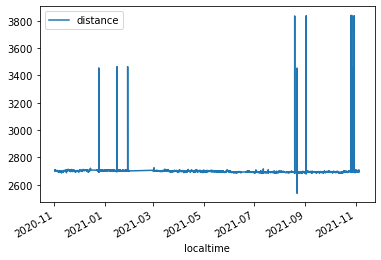

In [18]:
nc_hoyt5th.plot()

In [19]:
lower_hoyt5th = nc_hoyt5th['distance'].mean() - (nc_hoyt5th['distance'].std())
upper_hoyt5th = nc_hoyt5th['distance'].mean() + (nc_hoyt5th['distance'].std())

In [20]:
### Remove readings 3STDs from mean distance
nc_hoyt5th = nc_hoyt5th[nc_hoyt5th['distance'] < upper_hoyt5th]
nc_hoyt5th = nc_hoyt5th[nc_hoyt5th['distance'] > lower_hoyt5th]

<AxesSubplot:xlabel='localtime'>

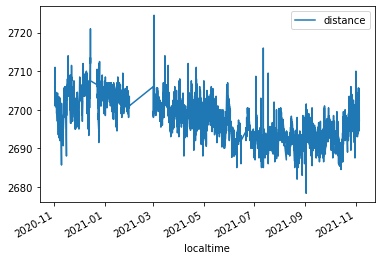

In [21]:
nc_hoyt5th.plot()

In [22]:
nc_hoyt5th = nc_hoyt5th.merge(temps, left_on= nc_hoyt5th.index, right_on= temps.localtime, how='inner')

Text(0, 0.5, 'Distance')

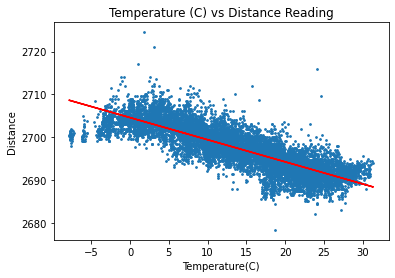

In [23]:
x_1 = nc_hoyt5th['temp_C']
x_2 = nc_hoyt5th['humidity']
y = nc_hoyt5th['distance']

plt.scatter(x_1, y, s=3)
m, b = np.polyfit(x_1, y, 1)
plt.plot(x_1, m*x_1 + b, color='red')
plt.title('Temperature (C) vs Distance Reading')
plt.xlabel('Temperature(C)')
plt.ylabel('Distance')

Text(0, 0.5, 'Distance')

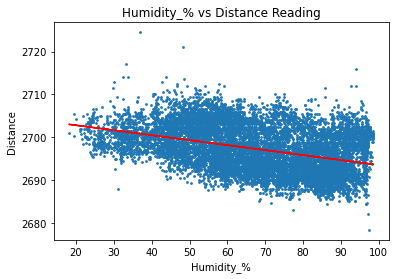

In [24]:
plt.scatter(x_2, y, s=3)
m, b = np.polyfit(x_2, y, 1)
plt.plot(x_2, m*x_2 + b, color='red')
plt.title('Humidity_% vs Distance Reading')
plt.xlabel('Humidity_%')
plt.ylabel('Distance')

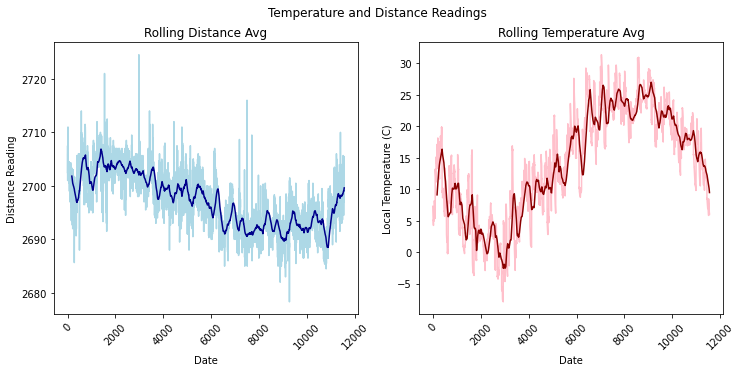

In [25]:
fig, ax = plt.subplots(1,2, figsize= (12,5))

nc_hoyt5th['distance'].plot(label='Dist', color='lightblue', ax=ax[0])
nc_hoyt5th['distance'].rolling(180).mean().plot(label='Dist', color='darkblue', ax=ax[0])
ax[0].set_title('Rolling Distance Avg')
ax[0].set_ylabel('Distance Reading')

nc_hoyt5th['temp_C'].plot(label='Temp', color='pink', ax=ax[1])
nc_hoyt5th['temp_C'].rolling(180).mean().plot(label='Temp', color='darkred', ax=ax[1])
plt.suptitle('Temperature and Distance Readings')
ax[1].set_title('Rolling Temperature Avg')
ax[1].set_ylabel('Local Temperature (C)')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    plt.xlabel('Date')

In [26]:
#### Temperature + Humdity

y = nc_hoyt5th['distance']
X = pd.DataFrame(nc_hoyt5th[['temp_C','humidity']])

n = 4

X_poly = X.copy()

for i in range(2,n+1):
    X_poly[f'temp_x{i}'] = nc_hoyt5th['temp_C']**i
    
for i in range(2,n+1):
    X_poly[f'humid_x{i}'] = nc_hoyt5th['humidity']**i


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3)

lm = sm.OLS(y_train, sm.add_constant(X_train)).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     3042.
Date:                Sun, 05 Dec 2021   Prob (F-statistic):               0.00
Time:                        22:11:54   Log-Likelihood:                -19296.
No. Observations:                8085   AIC:                         3.861e+04
Df Residuals:                    8076   BIC:                         3.867e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2703.2819      2.599   1039.931      0.000    2698.186    2708.378
temp_C         0.0853      0.018      4.811      0.000       0.051       0.120
humidity      -0.1298      0.192     -0.675      0.499      -0.507       0.247
temp_x2       -0.0627      0.003    -20.945      0.000      -0.069      -0.057
temp_x3        0.0020      0.000     10.354      0.000       0.002       0.002
temp_x4    -1.639e-05   3.91e-06     -4.193      0.000   -2.41e-05   -8.73e-06
humid_x2       0.0092      0.005      1.819      0.069      -0.001       0.019
humid_x3      -0.0002   5.65e-05     -2.887      0.004      -0.000   -5.23e-05
humid_x4      8.4e-07   2.27e-07      3.702      0.000    3.95e-07    1.28e-06
==============================================================================
Omnibus:                      518.273   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2199.199
Skew:                           0.155   Prob(JB):                         0.00
Kurtosis:                       5.536   Cond. No.                     3.37e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
pred = lm.predict(sm.add_constant(X_test))

r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test,pred)
print(r2, mae)


0.7639493371140933 1.9666341172628776


Text(0, 0.5, 'Distance')

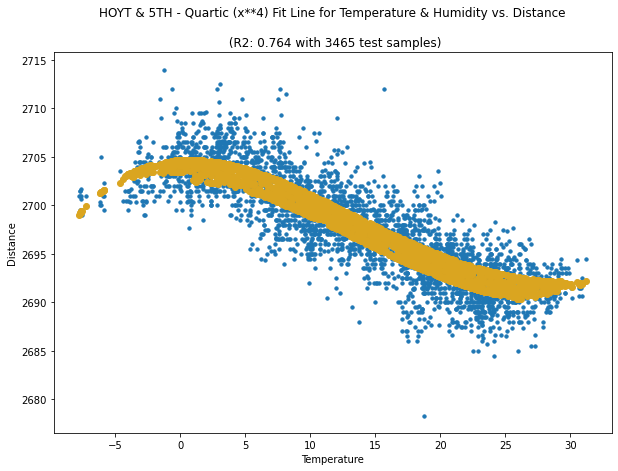

In [95]:
plt.figure(figsize=(10,7))

#plt.plot(X_train_temp, lm_temp.params[1]*X_train_temp+lm_temp.params[0], color='green')
plt.scatter(X_test['temp_C'], y_test, s=11)
plt.scatter(X_test['temp_C'], pred, color ='goldenrod')
plt.title('HOYT & 5TH - Quartic (x**4) Fit Line for Temperature & Humidity vs. Distance\
\n\n (R2: {:.3f} with {:n} test samples)'.format(r2, len(X_test)))
plt.xlabel('Temperature')
plt.ylabel('Distance')

In [39]:
lm.params

const       2.703282e+03
temp_C      8.533933e-02
humidity   -1.298398e-01
temp_x2    -6.265835e-02
temp_x3     2.022584e-03
temp_x4    -1.638970e-05
humid_x2    9.205999e-03
humid_x3   -1.630174e-04
humid_x4    8.399924e-07
dtype: float64

In [45]:
formula = lm.params['temp_C']*x_1 + lm.params['temp_x2']*(x_1)**2 + lm.params['temp_x3']*(x_1)**3 + lm.params['temp_x4']*(x_1)**4\
+ lm.params['humidity']*x_2 + lm.params['humid_x2']*(x_2)**2 + lm.params['humid_x3']*(x_2)**3 + lm.params['humid_x4']*(x_2)**4 + lm.params['const']


# Smith & 9th - Gowanus

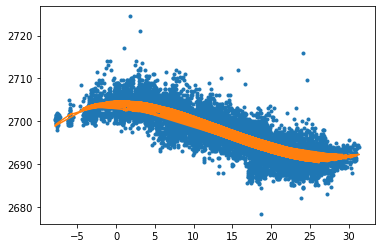

In [93]:
plt.plot(nc_hoyt5th['temp_C'], nc_hoyt5th['distance'], '.')
plt.plot(nc_hoyt5th['temp_C'], formula, '-')


In [179]:
##### Query "Smith & 9th" Sensor Data from InfluxDB

client = InfluxDBClient(host='floodnet-influxdb.sonycproject.com', ssl=True, port=0, database='db0')

measure = 'distance'
table = 'deployment-3'
dev_id = 'smith-and-9th'
days_back = 320

query = 'SELECT "%s" ' \
        'FROM "%s" ' \
        'WHERE "dev_id" = \'%s\' ' \
        'AND "time" >= now() - %id'\
        % (measure, table, dev_id, days_back)

data = client.query(query)

value_data = data.raw['series'][0]['values']

smith_9th = pd.DataFrame(value_data, columns =['datetime', 'distance'])

smith_9th['datetime'] = pd.to_datetime(smith_9th['datetime'], format='%Y-%m-%dT%H:%M:%S.%f')
smith_9th['localtime'] = smith_9th['datetime'].dt.tz_convert('US/Eastern')

smith_9th = pd.DataFrame(smith_9th.resample('10min', on='localtime').distance.mean()).reset_index() ## resample at 10_min intervals

print(smith_9th)

//anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'floodnet-influxdb.sonycproject.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


                      localtime  distance
0     2021-07-01 17:30:00-04:00    1464.0
1     2021-07-01 17:40:00-04:00       NaN
2     2021-07-01 17:50:00-04:00       NaN
3     2021-07-01 18:00:00-04:00    1992.0
4     2021-07-01 18:10:00-04:00    1283.0
...                         ...       ...
22627 2021-12-05 19:40:00-05:00    3040.0
22628 2021-12-05 19:50:00-05:00    3039.5
22629 2021-12-05 20:00:00-05:00    3039.0
22630 2021-12-05 20:10:00-05:00    3038.0
22631 2021-12-05 20:20:00-05:00    3038.0

[22632 rows x 2 columns]


In [180]:
n_smith_9th = smith_9th[(smith_9th.localtime.dt.hour > 22) | (smith_9th.localtime.dt.hour < 5)]
#n_smith_9th = n_smith_9th.set_index('localtime')

In [181]:
## Drop 5000s, anomalous Snowy February,  December 2020 Flood Event

cln_smith_9th = n_smith_9th[n_smith_9th['distance'] < 4500]
#cln_smith_9th = cln_smith_9th[cln_smith_9th.index.month != 2] ## Omit Snowy February
#cln_smith_9th = cln_smith_9th[~(cln_smith_9th.index.date == pd.Timestamp(month=1, year=2021, day=31))]# Remove 1/31 - also snowy
cln_smith_9th = cln_smith_9th[(cln_smith_9th.localtime.dt.date > pd.Timestamp(year=2021, month=7, day=14))]

<AxesSubplot:xlabel='localtime'>

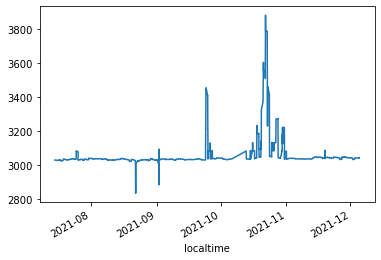

In [182]:
cln_smith_9th.set_index('localtime')['distance'].rolling(21).mean().plot()

In [183]:
lower_smith_9th = cln_smith_9th['distance'].mean() - (cln_smith_9th['distance'].std())
upper_smith_9th = cln_smith_9th['distance'].mean() + (cln_smith_9th['distance'].std())

In [184]:
cln_smith_9th = cln_smith_9th[cln_smith_9th['distance'] < upper_smith_9th]
cln_smith_9th = cln_smith_9th[cln_smith_9th['distance'] > lower_smith_9th]

In [185]:
cln_smith_9th = cln_smith_9th[cln_smith_9th['distance'] > 3000]

<AxesSubplot:xlabel='localtime'>

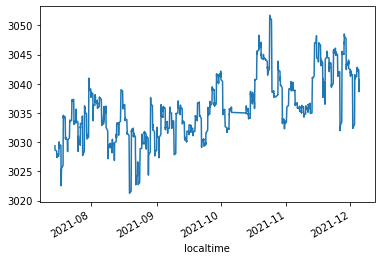

In [186]:
cln_smith_9th.set_index('localtime')['distance'].rolling(21).mean().plot()

In [187]:
temps = temps.reset_index()

In [188]:
## merge weather and sensor data and drop NaN values

cln_smith_9th = cln_smith_9th.merge(temps, on='localtime',how='inner').dropna()
cln_smith_9th = cln_smith_9th.set_index('localtime').dropna()

Text(0, 0.5, 'Distance')

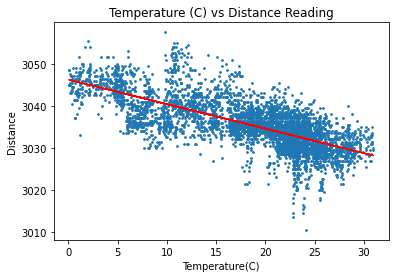

In [192]:
x_1 = cln_smith_9th['temp_C']
x_2 = cln_smith_9th['humidity']
y = cln_smith_9th['distance']

plt.scatter(x_1, y, s=3)
m, b = np.polyfit(x_1, y, 1)
plt.plot(x_1, m*x_1 + b, color='red')
plt.title('Temperature (C) vs Distance Reading')
plt.xlabel('Temperature(C)')
plt.ylabel('Distance')

Text(0, 0.5, 'Distance')

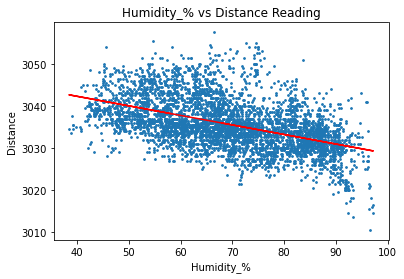

In [193]:
plt.scatter(x_2, y, s=3)
m, b = np.polyfit(x_2, y, 1)
plt.plot(x_2, m*x_2 + b, color='red')
plt.title('Humidity_% vs Distance Reading')
plt.xlabel('Humidity_%')
plt.ylabel('Distance')

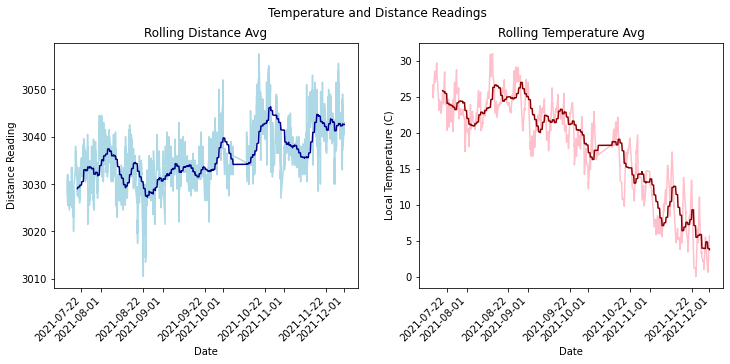

In [195]:
fig, ax = plt.subplots(1,2, figsize= (12,5))

cln_smith_9th['distance'].plot(label='Dist', color='lightblue', ax=ax[0])
cln_smith_9th['distance'].rolling(180).mean().plot(label='Dist', color='darkblue', ax=ax[0])
ax[0].set_title('Rolling Distance Avg')
ax[0].set_ylabel('Distance Reading')

cln_smith_9th['temp_C'].plot(label='Temp', color='pink', ax=ax[1])
cln_smith_9th['temp_C'].rolling(180).mean().plot(label='Temp', color='darkred', ax=ax[1])
plt.suptitle('Temperature and Distance Readings')
ax[1].set_title('Rolling Temperature Avg')
ax[1].set_ylabel('Local Temperature (C)')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    plt.xlabel('Date')

In [200]:
#### Temperature + Humdity

y = cln_smith_9th['distance']
X = pd.DataFrame(cln_smith_9th[['temp_C','humidity']])

n = 4

X_poly = X.copy()

for i in range(2,n+1):
    X_poly[f'temp_x{i}'] = cln_smith_9th['temp_C']**i
    
for i in range(2,n+1):
    X_poly[f'humid_x{i}'] = cln_smith_9th['humidity']**i


In [201]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3)

lm = sm.OLS(y_train, sm.add_constant(X_train)).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     693.5
Date:                Sun, 05 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:34:26   Log-Likelihood:                -8533.3
No. Observations:                3176   AIC:                         1.708e+04
Df Residuals:                    3167   BIC:                         1.714e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2869.3572     34.709     82.670      0.000    2801.304    2937.411
temp_C        -1.9408      0.196     -9.924      0.000      -2.324      -1.557
humidity      10.8044      2.135      5.060      0.000       6.617      14.991
temp_x2        0.2198      0.024      9.109      0.000       0.172       0.267
temp_x3       -0.0105      0.001     -9.224      0.000      -0.013      -0.008
temp_x4        0.0002   1.83e-05      8.610      0.000       0.000       0.000
humid_x2      -0.2405      0.048     -4.963      0.000      -0.336      -0.146
humid_x3       0.0024      0.000      4.895      0.000       0.001       0.003
humid_x4   -8.632e-06   1.76e-06     -4.914      0.000   -1.21e-05   -5.19e-06
==============================================================================
Omnibus:                      160.663   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              286.760
Skew:                           0.391   Prob(JB):                     5.38e-63
Kurtosis:                       4.247   Cond. No.                     1.87e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [202]:
pred = lm.predict(sm.add_constant(X_test))

r2 = r2_score(y_test, pred)
print(r2)

0.6520799168677682


Text(0, 0.5, 'Distance')

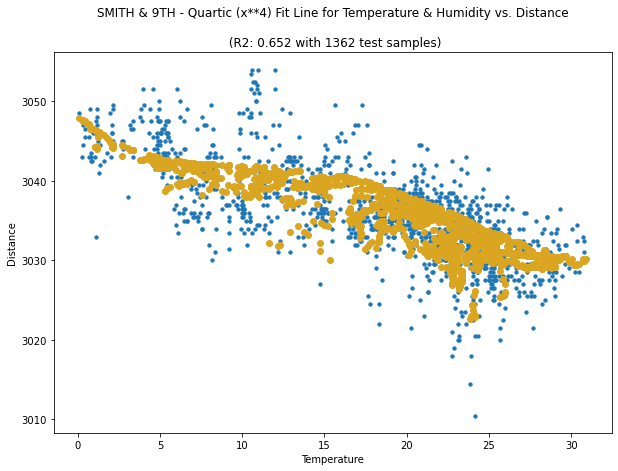

In [204]:
plt.figure(figsize=(10,7))

#plt.plot(X_train_temp, lm_temp.params[1]*X_train_temp+lm_temp.params[0], color='green')
plt.scatter(X_test['temp_C'], y_test, s=11)
plt.scatter(X_test['temp_C'], pred, color ='goldenrod')
plt.title('SMITH & 9TH - Quartic (x**4) Fit Line for Temperature & Humidity vs. Distance\
\n\n (R2: {:.3f} with {:n} test samples)'.format(r2, len(X_test)))
plt.xlabel('Temperature')
plt.ylabel('Distance')

# Carroll & 4th - Gowanus

In [217]:
##### Query "Carroll & 4th" Sensor Data from InfluxDB

client = InfluxDBClient(host='floodnet-influxdb.sonycproject.com', ssl=True, port=0, database='db0')

measure = 'distance'
table = 'deployment-3'
dev_id = 'carroll-and-4th'
days_back = 320

query = 'SELECT "%s" ' \
        'FROM "%s" ' \
        'WHERE "dev_id" = \'%s\' ' \
        'AND "time" >= now() - %id'\
        % (measure, table, dev_id, days_back)

data = client.query(query)

value_data = data.raw['series'][0]['values']

carroll4th = pd.DataFrame(value_data, columns =['datetime', 'distance'])

carroll4th['datetime'] = pd.to_datetime(carroll4th['datetime'], format='%Y-%m-%dT%H:%M:%S.%f')
carroll4th['localtime'] = carroll4th['datetime'].dt.tz_convert('US/Eastern')

carroll4th = pd.DataFrame(carroll4th.resample('10min', on='localtime').distance.mean()).reset_index() ## resample at 10_min intervals

print(carroll4th)

//anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'floodnet-influxdb.sonycproject.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


                      localtime  distance
0     2021-07-01 18:10:00-04:00    1307.0
1     2021-07-01 18:20:00-04:00    1308.0
2     2021-07-01 18:30:00-04:00    1307.0
3     2021-07-01 18:40:00-04:00    1306.5
4     2021-07-01 18:50:00-04:00    1307.0
...                         ...       ...
22318 2021-12-03 16:50:00-05:00       NaN
22319 2021-12-03 17:00:00-05:00       NaN
22320 2021-12-03 17:10:00-05:00       NaN
22321 2021-12-03 17:20:00-05:00       0.0
22322 2021-12-03 17:30:00-05:00       0.0

[22323 rows x 2 columns]


<AxesSubplot:>

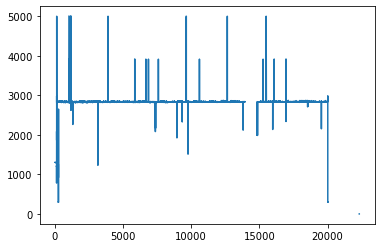

In [218]:
carroll4th['distance'].plot()

In [219]:
n_carroll4th = carroll4th[(carroll4th.localtime.dt.hour > 22) | (carroll4th.localtime.dt.hour < 5)]

In [220]:
cln_carroll4th = n_carroll4th[n_carroll4th['distance'] < 4500]
#cln_smith_9th = cln_smith_9th[cln_smith_9th.index.month != 2] ## Omit Snowy February
#cln_smith_9th = cln_smith_9th[~(cln_smith_9th.index.date == pd.Timestamp(month=1, year=2021, day=31))]# Remove 1/31 - also snowy
cln_carroll4th = cln_carroll4th[(cln_carroll4th.localtime.dt.date > pd.Timestamp(year=2021, month=7, day=14))]

In [221]:
lower_carroll4th = cln_carroll4th['distance'].mean() - (cln_carroll4th['distance'].std())
upper_carroll4th = cln_carroll4th['distance'].mean() + (cln_carroll4th['distance'].std())

In [222]:
cln_carroll4th = cln_carroll4th[cln_carroll4th['distance'] < upper_carroll4th]
cln_carroll4th = cln_carroll4th[cln_carroll4th['distance'] > lower_carroll4th]

<AxesSubplot:xlabel='localtime'>

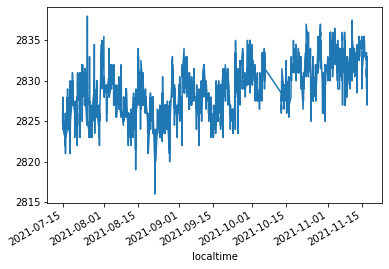

In [223]:
cln_carroll4th.set_index('localtime')['distance'].plot()

In [224]:
cln_carroll4th = cln_carroll4th.merge(temps, on='localtime',how='inner').dropna()

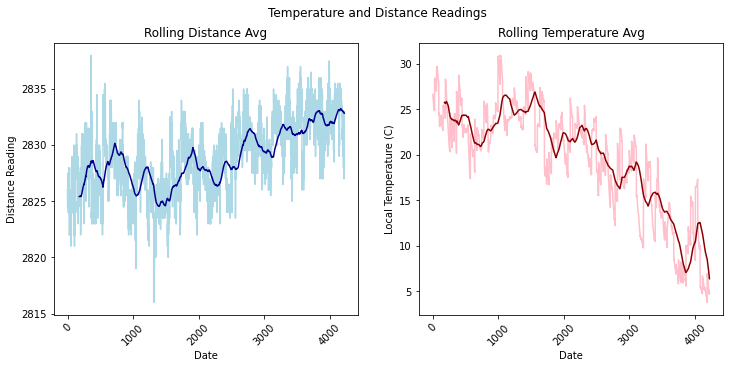

In [225]:
fig, ax = plt.subplots(1,2, figsize= (12,5))

cln_carroll4th['distance'].plot(label='Dist', color='lightblue', ax=ax[0])
cln_carroll4th['distance'].rolling(180).mean().plot(label='Dist', color='darkblue', ax=ax[0])
ax[0].set_title('Rolling Distance Avg')
ax[0].set_ylabel('Distance Reading')

cln_carroll4th['temp_C'].plot(label='Temp', color='pink', ax=ax[1])
cln_carroll4th['temp_C'].rolling(180).mean().plot(label='Temp', color='darkred', ax=ax[1])
plt.suptitle('Temperature and Distance Readings')
ax[1].set_title('Rolling Temperature Avg')
ax[1].set_ylabel('Local Temperature (C)')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    plt.xlabel('Date')

Text(0, 0.5, 'Distance')

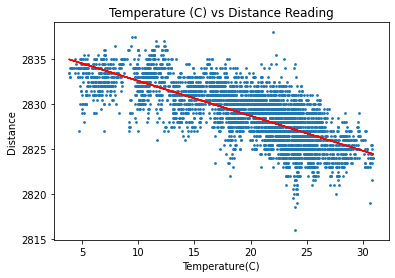

In [227]:
x_1 = cln_carroll4th['temp_C']
x_2 = cln_carroll4th['humidity']
y = cln_carroll4th['distance']

plt.scatter(x_1, y, s=3)
m, b = np.polyfit(x_1, y, 1)
plt.plot(x_1, m*x_1 + b, color='red')
plt.title('Temperature (C) vs Distance Reading')
plt.xlabel('Temperature(C)')
plt.ylabel('Distance')

Text(0, 0.5, 'Distance')

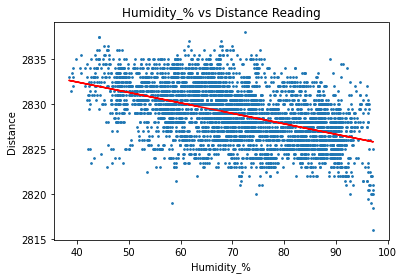

In [228]:
plt.scatter(x_2, y, s=3)
m, b = np.polyfit(x_2, y, 1)
plt.plot(x_2, m*x_2 + b, color='red')
plt.title('Humidity_% vs Distance Reading')
plt.xlabel('Humidity_%')
plt.ylabel('Distance')

In [230]:
#### Temperature + Humdity

y = cln_carroll4th['distance']
X = pd.DataFrame(cln_carroll4th[['temp_C','humidity']])

n = 4

X_poly = X.copy()

for i in range(2,n+1):
    X_poly[f'temp_x{i}'] = cln_carroll4th['temp_C']**i
    
for i in range(2,n+1):
    X_poly[f'humid_x{i}'] = cln_carroll4th['humidity']**i


In [231]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3)

lm = sm.OLS(y_train, sm.add_constant(X_train)).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     993.7
Date:                Sun, 05 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:38:00   Log-Likelihood:                -5682.1
No. Observations:                2955   AIC:                         1.138e+04
Df Residuals:                    2946   BIC:                         1.144e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2810.0669     16.621    169.065      0.000    2777.477    2842.657
temp_C        -0.8243      0.294     -2.803      0.005      -1.401      -0.248
humidity       1.6611      1.000      1.661      0.097      -0.300       3.622
temp_x2        0.0978      0.029      3.390      0.001       0.041       0.154
temp_x3       -0.0048      0.001     -4.140      0.000      -0.007      -0.003
temp_x4     6.803e-05   1.63e-05      4.163      0.000     3.6e-05       0.000
humid_x2      -0.0378      0.022     -1.686      0.092      -0.082       0.006
humid_x3       0.0004      0.000      1.678      0.093    -6.2e-05       0.001
humid_x4   -1.369e-06   7.92e-07     -1.729      0.084   -2.92e-06    1.84e-07
==============================================================================
Omnibus:                       78.504   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.670
Skew:                           0.024   Prob(JB):                     1.07e-41
Kurtosis:                       4.237   Cond. No.                     1.99e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [232]:
pred = lm.predict(sm.add_constant(X_test))

r2 = r2_score(y_test, pred)
print(r2)

0.7214723109580936


Text(0, 0.5, 'Distance')

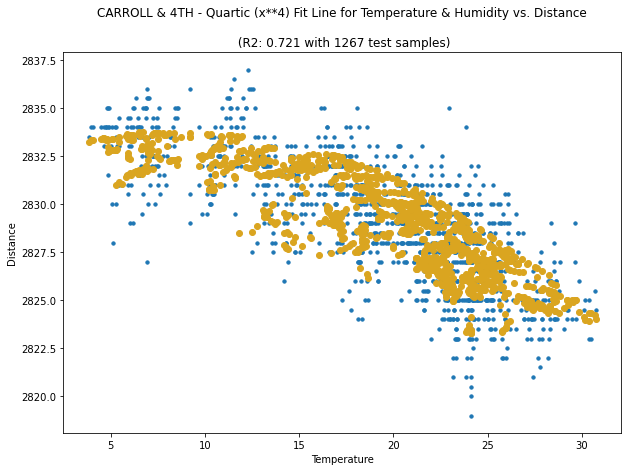

In [234]:
plt.figure(figsize=(10,7))

#plt.plot(X_train_temp, lm_temp.params[1]*X_train_temp+lm_temp.params[0], color='green')
plt.scatter(X_test['temp_C'], y_test, s=11)
plt.scatter(X_test['temp_C'], pred, color ='goldenrod')
plt.title('CARROLL & 4TH - Quartic (x**4) Fit Line for Temperature & Humidity vs. Distance\
\n\n (R2: {:.3f} with {:n} test samples)'.format(r2, len(X_test)))
plt.xlabel('Temperature')
plt.ylabel('Distance')

# Russell St. - Jamaica Bay

In [235]:
##### Query "Russell St - Jamaica Bay" Sensor Data from InfluxDB

client = InfluxDBClient(host='floodnet-influxdb.sonycproject.com', ssl=True, port=0, database='db0')

measure = 'distance'
table = 'msg'
app_id = 'deployment_two_app'
dev_id = 'sensor_8'
days_back = 320

query = 'SELECT "%s" ' \
        'FROM "%s" ' \
        'WHERE "app_id" = \'%s\' ' \
        'AND "dev_id" = \'%s\' ' \
        'AND "time" >= now() - %id'\
        % (measure, table, app_id, dev_id, days_back)

data = client.query(query)

value_data = data.raw['series'][0]['values']

russ_st = pd.DataFrame(value_data, columns =['datetime', 'distance'])

russ_st['datetime'] = pd.to_datetime(russ_st['datetime'], format='%Y-%m-%dT%H:%M:%S.%f')
russ_st['localtime'] = russ_st['datetime'].dt.tz_convert('US/Eastern')

russ_st = pd.DataFrame(russ_st.resample('10min', on='localtime').distance.mean()).reset_index() ## resample at 10_min intervals

print(russ_st)

//anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'floodnet-influxdb.sonycproject.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


                      localtime     distance
0     2021-02-22 19:00:00-05:00  1233.000000
1     2021-02-22 19:10:00-05:00  1232.000000
2     2021-02-22 19:20:00-05:00  1232.000000
3     2021-02-22 19:30:00-05:00  1231.000000
4     2021-02-22 19:40:00-05:00  1232.000000
...                         ...          ...
36846 2021-11-05 17:00:00-04:00  2711.150000
36847 2021-11-05 17:10:00-04:00  2709.473684
36848 2021-11-05 17:20:00-04:00  2708.250000
36849 2021-11-05 17:30:00-04:00  2707.368421
36850 2021-11-05 17:40:00-04:00  2706.400000

[36851 rows x 2 columns]


<AxesSubplot:xlabel='localtime'>

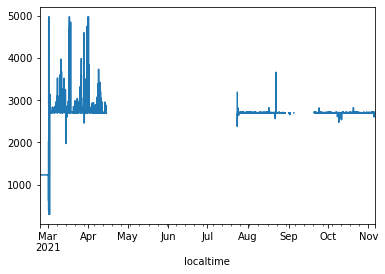

In [236]:
russ_st.set_index('localtime')['distance'].plot()

# Davenport Court - Jamaica Bay

In [124]:
##### Query "Davenport Court - Jamaica Bay" Sensor Data from InfluxDB

client = InfluxDBClient(host='floodnet-influxdb.sonycproject.com', ssl=True, port=0, database='db0')

measure = 'distance'
table = 'msg'
app_id = 'deployment_two_app'
dev_id = 'sensor_9'
days_back = 320

query = 'SELECT "%s" ' \
        'FROM "%s" ' \
        'WHERE "app_id" = \'%s\' ' \
        'AND "dev_id" = \'%s\' ' \
        'AND "time" >= now() - %id'\
        % (measure, table, app_id, dev_id, days_back)

data = client.query(query)

value_data = data.raw['series'][0]['values']

dav_ct = pd.DataFrame(value_data, columns =['datetime', 'distance'])

dav_ct['datetime'] = pd.to_datetime(dav_ct['datetime'], format='%Y-%m-%dT%H:%M:%S.%f')
dav_ct['localtime'] = dav_ct['datetime'].dt.tz_convert('US/Eastern')

dav_ct = pd.DataFrame(dav_ct.resample('10min', on='localtime').distance.mean()).reset_index() ## resample at 10_min intervals

print(dav_ct)

//anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'floodnet-influxdb.sonycproject.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


                      localtime  distance
0     2021-02-22 19:00:00-05:00    1252.0
1     2021-02-22 19:10:00-05:00    1252.5
2     2021-02-22 19:20:00-05:00    1270.0
3     2021-02-22 19:30:00-05:00    1250.5
4     2021-02-22 19:40:00-05:00    1251.0
...                         ...       ...
36846 2021-11-05 17:00:00-04:00       NaN
36847 2021-11-05 17:10:00-04:00    2669.0
36848 2021-11-05 17:20:00-04:00    4963.0
36849 2021-11-05 17:30:00-04:00    4961.0
36850 2021-11-05 17:40:00-04:00    4961.0

[36851 rows x 2 columns]


<AxesSubplot:xlabel='localtime'>

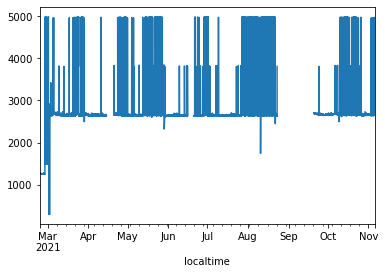

In [125]:
dav_ct.set_index('localtime')['distance'].plot()

In [126]:
n_dav_ct = dav_ct[(dav_ct.localtime.dt.hour > 22) | (dav_ct.localtime.dt.hour < 5)]

In [127]:
cln_dav_ct = n_dav_ct[n_dav_ct['distance'] < 3500]
cln_dav_ct = cln_dav_ct[(cln_dav_ct.localtime.dt.date > pd.Timestamp(year=2021, month=3, day=5))]

<AxesSubplot:xlabel='localtime'>

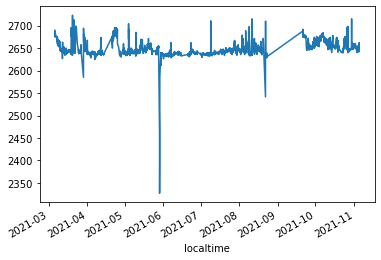

In [128]:
cln_dav_ct.set_index('localtime')['distance'].plot()

In [129]:
lowercln_dav_ct = cln_dav_ct['distance'].mean() - (cln_dav_ct['distance'].std())
uppercln_dav_ct = cln_dav_ct['distance'].mean() + (cln_dav_ct['distance'].std())

In [130]:
cln_dav_ct = cln_dav_ct[cln_dav_ct['distance'] < uppercln_dav_ct]
cln_dav_ct = cln_dav_ct[cln_dav_ct['distance'] > lowercln_dav_ct]

<AxesSubplot:xlabel='localtime'>

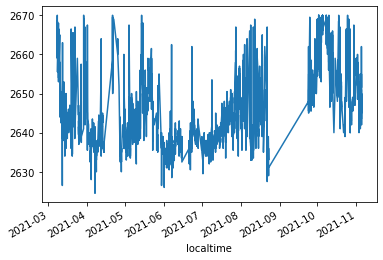

In [131]:
cln_dav_ct.set_index('localtime')['distance'].plot()

In [132]:
cln_dav_ct = cln_dav_ct.merge(temps, on='localtime',how='inner').dropna()

Text(0, 0.5, 'Distance')

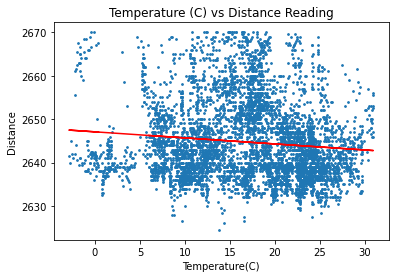

In [133]:
x_1 = cln_dav_ct['temp_C']
x_2 = cln_dav_ct['humidity']
y = cln_dav_ct['distance']

plt.scatter(x_1, y, s=3)
m, b = np.polyfit(x_1, y, 1)
plt.plot(x_1, m*x_1 + b, color='red')
plt.title('Temperature (C) vs Distance Reading')
plt.xlabel('Temperature(C)')
plt.ylabel('Distance')

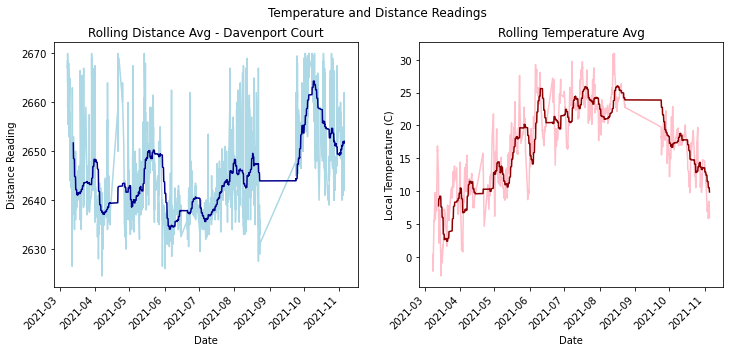

In [134]:
fig, ax = plt.subplots(1,2, figsize= (12,5))

cln_dav_ct.set_index('localtime')['distance'].plot(label='Dist', color='lightblue', ax=ax[0])
cln_dav_ct.set_index('localtime')['distance'].rolling(180).mean().plot(label='Dist', color='darkblue', ax=ax[0])
ax[0].set_title('Rolling Distance Avg - Davenport Court')
ax[0].set_ylabel('Distance Reading')

cln_dav_ct.set_index('localtime')['temp_C'].plot(label='Temp', color='pink', ax=ax[1])
cln_dav_ct.set_index('localtime')['temp_C'].rolling(180).mean().plot(label='Temp', color='darkred', ax=ax[1])
plt.suptitle('Temperature and Distance Readings')
ax[1].set_title('Rolling Temperature Avg')
ax[1].set_ylabel('Local Temperature (C)')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    plt.xlabel('Date')

In [249]:
#### Temperature + Humdity

y = cln_dav_ct['distance']
X = pd.DataFrame(cln_dav_ct[['temp_C','humidity']])

n = 4

X_poly = X.copy()

for i in range(2,n+1):
    X_poly[f'temp_x{i}'] = cln_dav_ct['temp_C']**i
    
for i in range(2,n+1):
    X_poly[f'humid_x{i}'] = cln_dav_ct['humidity']**i


In [250]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3)

lm = sm.OLS(y_train, sm.add_constant(X_train)).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     104.0
Date:                Sun, 05 Dec 2021   Prob (F-statistic):          9.15e-158
Time:                        21:13:08   Log-Likelihood:                -13867.
No. Observations:                3939   AIC:                         2.775e+04
Df Residuals:                    3930   BIC:                         2.781e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2595.7582      9.710    267.341      0.000    2576.722    2614.794
temp_C        -2.6896      0.272     -9.905      0.000      -3.222      -2.157
humidity       2.8743      0.738      3.897      0.000       1.428       4.320
temp_x2        0.4435      0.038     11.733      0.000       0.369       0.518
temp_x3       -0.0229      0.002    -11.733      0.000      -0.027      -0.019
temp_x4        0.0004   3.33e-05     10.897      0.000       0.000       0.000
humid_x2      -0.0540      0.020     -2.734      0.006      -0.093      -0.015
humid_x3       0.0004      0.000      1.981      0.048    4.67e-06       0.001
humid_x4    -1.45e-06   9.05e-07     -1.602      0.109   -3.22e-06    3.24e-07
==============================================================================
Omnibus:                      341.500   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              435.494
Skew:                           0.775   Prob(JB):                     2.71e-95
Kurtosis:                       3.503   Cond. No.                     3.02e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.02e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:>

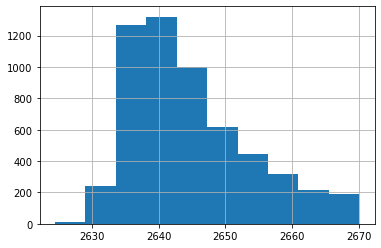

In [135]:
cln_dav_ct['distance'].hist()

In [251]:
pred = lm.predict(sm.add_constant(X_test))

r2 = r2_score(y_test, pred)
print(r2)

0.14476598219009418


Text(0, 0.5, 'Distance')

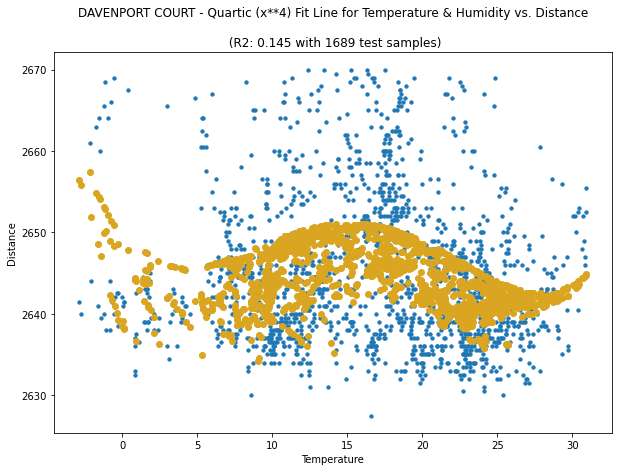

In [253]:
plt.figure(figsize=(10,7))

#plt.plot(X_train_temp, lm_temp.params[1]*X_train_temp+lm_temp.params[0], color='green')
plt.scatter(X_test['temp_C'], y_test, s=11)
plt.scatter(X_test['temp_C'], pred, color ='goldenrod')
plt.title('DAVENPORT COURT - Quartic (x**4) Fit Line for Temperature & Humidity vs. Distance\
\n\n (R2: {:.3f} with {:n} test samples)'.format(r2, len(X_test)))
plt.xlabel('Temperature')
plt.ylabel('Distance')

In [259]:
load_historic_weather_data()

,station,valid,temp_celcius,dewp_celcius,rh_percentage,wind_dir,wind_speed_mph,sea_level_pressure_mb,precipitation_mm,visibility_miles,gust_mph,peak_wind_gust_mph,datetime
11,JFK,2020-01-01 00:51,6.11,3.89,85.66,210.0,10.35,1003.7,0.0,10.0,NaN,NaN,2019-12-31 19:00:00-05:00
24,JFK,2020-01-01 01:51,6.72,4.39,85.06,250.0,17.25,1004.2,0.0,10.0,NaN,NaN,2019-12-31 20:00:00-05:00
37,JFK,2020-01-01 02:51,6.11,1.72,73.45,270.0,14.95,1003.9,NaN,10.0,NaN,33.35,2019-12-31 21:00:00-05:00
50,JFK,2020-01-01 03:51,6.11,1.11,70.30,270.0,17.25,1004.0,0.0,10.0,20.7,NaN,2019-12-31 22:00:00-05:00
63,JFK,2020-01-01 04:51,5.61,0.00,67.17,270.0,14.95,1004.4,0.0,10.0,NaN,NaN,2019-12-31 23:00:00-05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190402,JFK,2021-11-01 18:51,16.11,1.11,36.19,290.0,11.50,1018.1,0.0,10.0,NaN,NaN,2021-11-01 14:00:00-04:00
190415,JFK,2021-11-01 19:51,16.11,0.00,33.40,270.0,14.95,1018.5,0.0,10.0,NaN,NaN,2021-11-01 15:00:00-04:00
190428,JFK,2021-11-01 20:51,15.00,0.00,35.87,310.0,13.80,1018.7,0.0,10.0,NaN,NaN,2021-11-01 16:00:00-04:00
190441,JFK,2021-11-01 21:51,13.89,-0.61,36.86,290.0,11.50,1019.2,0.0,10.0,NaN,NaN,2021-11-01 17:00:00-04:00
